Importing relevant libaries and packages.

In [85]:
import numpy as np
import pandas as pd
import os
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pydicom
from skimage.transform import resize
import matplotlib.patches as patches
from tqdm import tqdm 
import math
import graphviz
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Load labels and display first 5 rows. Notice how the first 4 patients did not have pneumonia and do not have a box attahed, while the last patient has pneumonia and has a box.

In [2]:
train_labels = pd.read_csv('rsna-pneumonia-detection-challenge\stage_2_train_labels.csv')
train_labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


Creating function designed to resize an image to fit within a fixed input_size of 244 pixels while adjusting aspect ratio and bounding box (if there is one) accordingly.

In [3]:
input_size = 244

def format_image(img, box):
    height, width = img.shape 
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized = cv.resize(img, new_size, interpolation= cv.INTER_LINEAR)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    x, y, w, h = (box[0], box[1], box[2], box[3]) if box[0] else (0.0,0.0,0.0,0.0)
    new_box = [int((x)/ r), int((y)/ r), int(w/ r), int(h/ r)] if box[0] else [0.0,0.0,0.0,0.0]

    return new_image, new_box

Processes a sample image (00436515-...) from the training data, to visualize how the data looks. This image is one with pneumonia.

[62, 36, 50, 90]


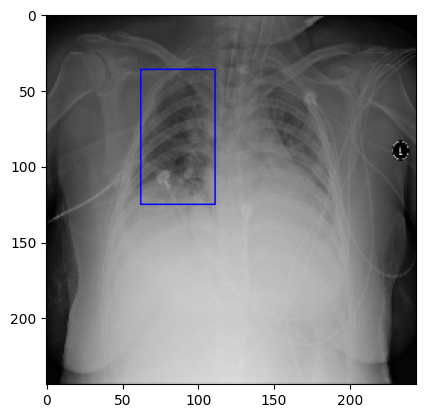

In [6]:
datapath = 'rsna-pneumonia-detection-challenge\stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm'
temp_img = pydicom.dcmread(datapath).pixel_array
temp_box = train_labels[train_labels['patientId'] == '00436515-870c-4b36-a041-de91049b9ab4'].iloc[0, 1:].values

temp_img_formated, box = format_image(temp_img, temp_box)
print(box)
temp_color_img = cv.cvtColor(temp_img_formated, cv.COLOR_GRAY2RGB)

cv.rectangle(temp_color_img, box, (0, 0, 255), 1)

plt.imshow(temp_color_img)
# plt.axis("off")
plt.show()


Creates and uses a function to load and process the DICOM images of Lung CTs and labels.

In [7]:
def data_load(dataset, batch_size=3, full_data_path=r"rsna-pneumonia-detection-challenge\stage_2_train_images", image_ext=".dcm",ds_type='not_trian'):
    X = []
    Y = []

    for index, row in tqdm(dataset.iterrows(), total=len(dataset), desc="Loading data"):
        filename = row['patientId']

        temp_img = pydicom.dcmread(os.path.join(full_data_path, filename + image_ext)).pixel_array
        
        temp_box = [row['x'], row['y'], row['width'], row['height']] if not math.isnan(row['x']) else [0.0, 0.0, 0.0, 0.0]

        img, box = format_image(temp_img, temp_box)

        img = img.astype(float) / 255.
        box = np.asarray(box, dtype=float) / input_size

        label = np.append(box, row['Target'])

        X.append(img)
        Y.append(label)
    
    X = np.array(X)
    data_X_len = len(X)
    X = np.expand_dims(X, axis=3)
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    Y = tf.convert_to_tensor(Y, dtype=tf.float32)
    
    result = tf.data.Dataset.from_tensor_slices((X, Y))

    return result,data_X_len
raw_train_ds,train_len = data_load(train_labels[:5200],ds_type="train")
print(train_len)
raw_valid_ds,valid_len = data_load(train_labels[5200:5900],ds_type="not train")
raw_test_ds, test_len = data_load(train_labels[5900:6501],ds_type="not train")

Loading data: 100%|██████████| 5200/5200 [01:00<00:00, 86.67it/s]


5200


Loading data: 100%|██████████| 601/601 [00:07<00:00, 85.53it/s]


Defines a function to ready the (images, label) pair to be used in TensorFlow. The two classes are "has pneomonia" and "doesn't have pneumonia," followed by the box dimensions.

In [8]:
def format_instance(image, label):
    return image, (tf.one_hot(int(label[4]), 2), [label[0], label[1], label[2], label[3]])

Defines three function to optimize the training/validation/testing dataset respecively for the tensor flow model.

In [10]:
BATCH_SIZE = 32

def tune_training_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # The dataset be repeated indefinitely.
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

def tune_validation_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(dataset) // 4)
    dataset = dataset.repeat()
    return dataset

def tune_test_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(1) 
    dataset = dataset.repeat()
    return dataset

Using the above functions, preparing the training and validation datasets.

In [11]:
train_ds = tune_training_ds(raw_train_ds)
validation_ds = tune_validation_ds(raw_valid_ds)
test_ds = tune_test_ds(raw_test_ds)

Visualizing one batch of the training data set. Again, see that some patients don't have pneumonia.

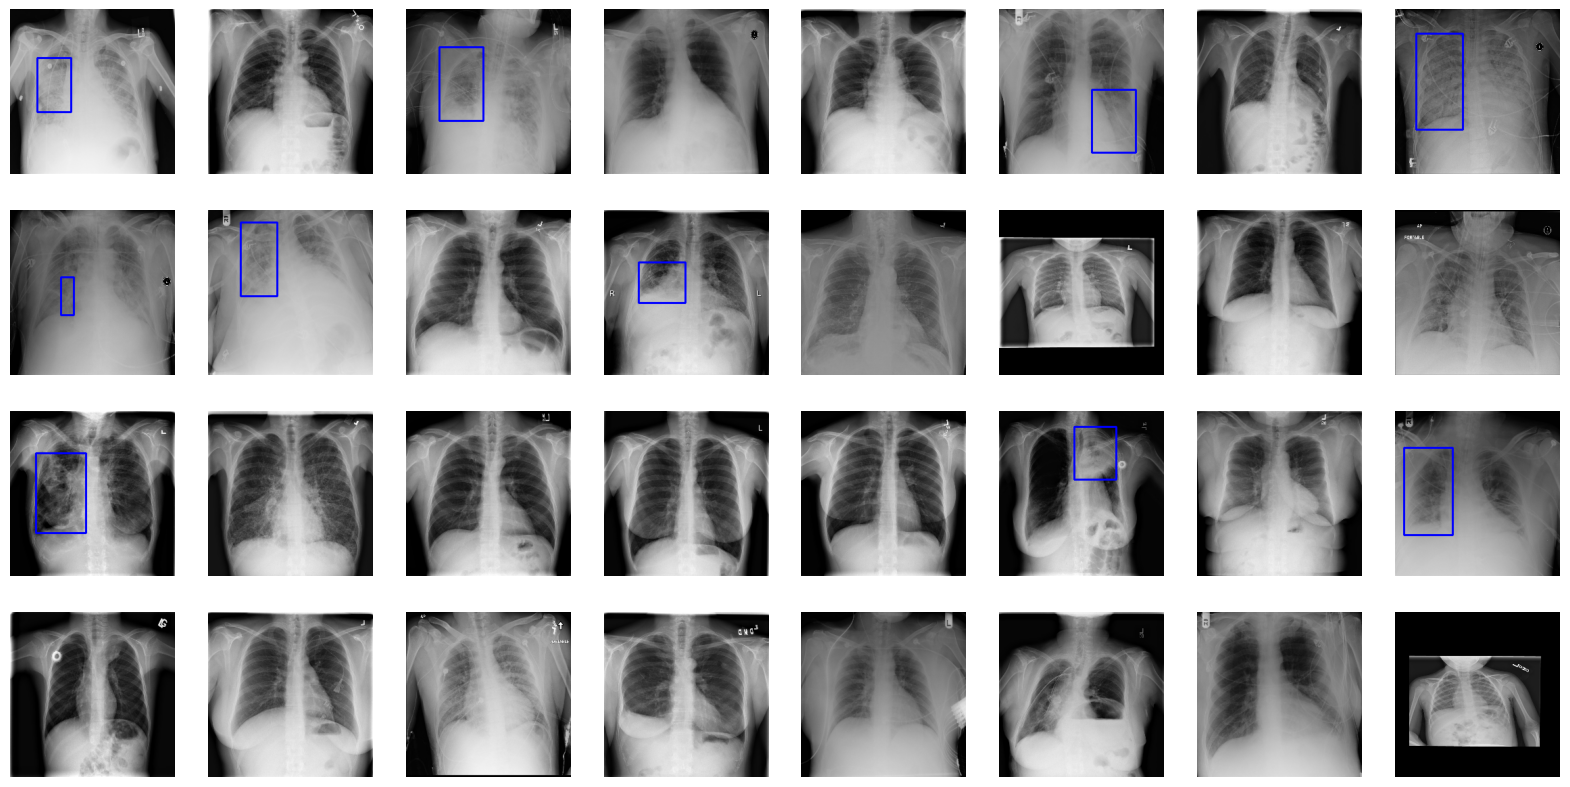

In [12]:
plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(4, BATCH_SIZE//4, i + 1)
        label = labels[0][i]
        box = (labels[1][i] * input_size)
        box = tf.cast(box, tf.int32)

        image = images[i].numpy().astype("float") * 255.0
        image = image.astype(np.uint8)
        image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

        color = (0, 0, 255)
        if label[0] > 0:
            color = (0, 255, 0)

        cv.rectangle(image_color, box.numpy(), color, 2)

        plt.imshow(image_color)
        plt.axis("off")

Building model architecture to perform classification (detecting pneumonia)(secondary) and bounding box regression (localizing pneumonia in X-ray images).

In [13]:
DROPOUT_FACTOR = 0.5

def build_feature_extractor(inputs):

    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(input_size, input_size, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    return x

def build_model_adaptor(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    return x

def build_classifier_head(inputs):
    return tf.keras.layers.Dense(2, activation='softmax', name = 'classifier_head')(inputs)

def build_regressor_head(inputs):
    return tf.keras.layers.Dense(units = 4, name = 'regressor_head')(inputs)

def build_model(inputs):
    
    feature_extractor = build_feature_extractor(inputs)

    model_adaptor = build_model_adaptor(feature_extractor)

    classification_head = build_classifier_head(model_adaptor)

    regressor_head = build_regressor_head(model_adaptor)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])

    model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss = {'classifier_head' : 'categorical_crossentropy', 'regressor_head' : 'mse' }, 
              metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })

    return model

Initializing the model with the standardized image dimensions and displaying the model structure.

In [14]:
model = build_model(tf.keras.layers.Input(shape=(input_size, input_size, 1,)))

model.summary()

C:\Users\Sanan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 244, 244,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 242, 242,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 121, 121,  │          0 │ conv2d[0][0]      │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 119, 119,  │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 59, 59,    │          0 │ conv2d_1[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 57, 57,    │     18,496 │ average_pooling2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 57, 57,    │          0 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_2 │ (None, 28, 28,    │          0 │ dropout[0][0]     │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50176)     │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │  3,211,328 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier_head     │ (None, 2)         │        130 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regressor_head      │ (None, 4)         │        260 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,235,014 (12.34 MB)

 Trainable params: 3,235,014 (12.34 MB)

 Non-trainable params: 0 (0.00 B)

Visualizing model strucutre in another way.

In [16]:
plot_model(model, show_shapes=True, show_layer_names=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


Training the model with 100 epochs.

In [17]:
history = model.fit(train_ds,
                    steps_per_epoch=(len(raw_train_ds) // BATCH_SIZE),
                    validation_data=validation_ds, validation_steps=1, 
                    epochs=100)

Epoch 1/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 40s 217ms/step - classifier_head_accuracy: 0.6452 - classifier_head_loss: 0.6567 - loss: 0.7293 - regressor_head_loss: 0.0725 - regressor_head_mse: 0.0725 - val_classifier_head_accuracy: 0.8171 - val_classifier_head_loss: 0.3978 - val_loss: 0.4143 - val_regressor_head_loss: 0.0164 - val_regressor_head_mse: 0.0164
Epoch 2/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 35s 214ms/step - classifier_head_accuracy: 0.7615 - classifier_head_loss: 0.5063 - loss: 0.5366 - regressor_head_loss: 0.0303 - regressor_head_mse: 0.0303 - val_classifier_head_accuracy: 0.7657 - val_classifier_head_loss: 0.4577 - val_loss: 0.4764 - val_regressor_head_loss: 0.0186 - val_regressor_head_mse: 0.0186
Epoch 3/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 34s 208ms/step - classifier_head_accuracy: 0.7741 - classifier_head_loss: 0.4907 - loss: 0.5208 - regressor_head_loss: 0.0300 - regressor_head_mse: 0.0300 - val_classifier_head_accuracy: 0.7600 - val_classifier_head_loss: 0.4983 - val_loss: 0.5171

Visualizing the training and validation accuracy of our classification model across epochs.

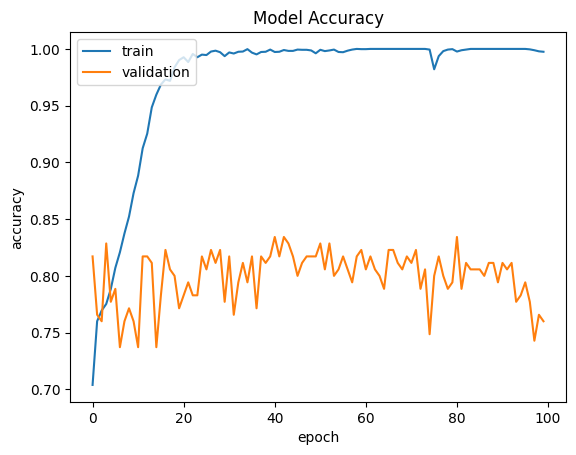

In [18]:
plt.plot(history.history['classifier_head_accuracy'])
plt.plot(history.history['val_classifier_head_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Defining function to calculate IoU, using the formula in the kaggle challenge overview.

In [19]:
def intersection_over_union(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    interWidth = max(0, xB - xA)
    interHeight = max(0, yB - yA)
    interArea = interWidth * interHeight

    boxAArea = boxA[2] * boxA[3] 
    boxBArea = boxB[2] * boxB[3]  

    if boxAArea == 0 or boxBArea == 0:
        return 0.0 

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

Visualizing 20 test predicitons for the model along with the calculated IoU. Red box printed if a case was wrongly classified. Otherwise, printed a green box if correctly classified. The box label is unmasked if the model classified it as not having pneumonia and masked if it was classified as having pneumonia.

20


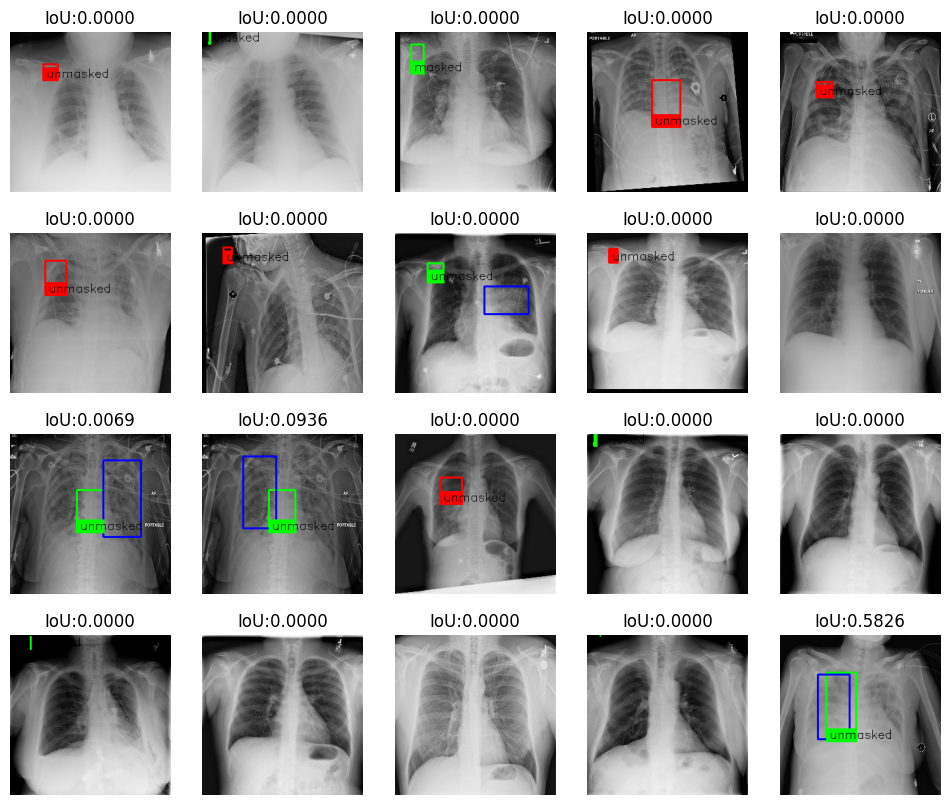

In [ ]:
plt.figure(figsize=(12, 10))

test_list = list(test_ds.take(20).as_numpy_iterator())

image, labels = test_list[0]

for i in range(len(test_list)):

    ax = plt.subplot(4, 5, i + 1)
    image, labels = test_list[i]

    predictions = model(image)

    predicted_box = predictions[1][0] * input_size
    predicted_box = tf.cast(predicted_box, tf.int32)

    predicted_label = predictions[0][0]

    image = image[0]

    actual_label = labels[0][0]
    actual_box = labels[1][0] * input_size
    actual_box = tf.cast(actual_box, tf.int32)

    image = image.astype("float") * 255.0
    image = image.astype(np.uint8)
    image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

    color = (255, 0, 0)
    # print box red if predicted and actual label do not match
    if (predicted_label[0] > 0.5 and actual_label[0] > 0) or (predicted_label[0] < 0.5 and actual_label[0] == 0):
        color = (0, 255, 0)

    img_label = "unmasked"
    if predicted_label[0] > 0.5:
        img_label = "masked"

    predicted_box_n = predicted_box.numpy()
    cv.rectangle(image_color, predicted_box_n, color, 2)
    cv.rectangle(image_color, actual_box.numpy(), (0, 0, 255), 2)
    cv.rectangle(image_color, (predicted_box_n[0], predicted_box_n[1] + predicted_box_n[3] - 20), (predicted_box_n[0] + predicted_box_n[2], predicted_box_n[1] + predicted_box_n[3]), color, -1)
    cv.putText(image_color, img_label, (predicted_box_n[0] + 5, predicted_box_n[1] + predicted_box_n[3] - 5), cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0))

    IoU = intersection_over_union(predicted_box.numpy(), actual_box.numpy())

    plt.title("IoU:" + format(IoU, '.4f'))
    plt.imshow(image_color)
    plt.axis("off")

Evaluation of the trained model's predictions on test set: calculating accuracy & Intersection over Union (IoU). Also created confusion matrix for the categorization.

Test Data Size: 601


<Figure size 1200x1000 with 0 Axes>

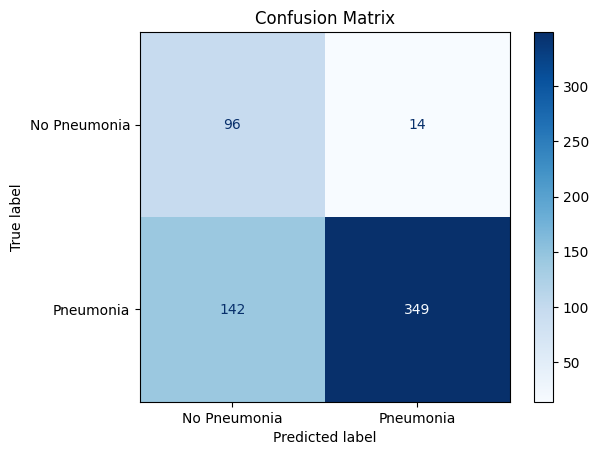

Recall: 0.7108, Precision: 0.9614, F1 Score: 0.8173
Accuracy: 0.7404
Mean IoU: 0.0148


In [111]:
output_dir = "output_predictions"
os.makedirs(output_dir, exist_ok=True)

plt.figure(figsize=(12, 10))

test_list = list(test_ds.take(len(raw_test_ds)).as_numpy_iterator())
print(f"Test Data Size: {len(test_list)}")

correct_count = 0
total_count = 0
iou_list = []
label_predicted = []
label_actual = []

for i in range(len(test_list)):

    image, labels = test_list[i]
    predictions = model(image)

    predicted_box = predictions[1][0] * input_size
    predicted_box = tf.cast(predicted_box, tf.int32)
    predicted_label = predictions[0][0]

    actual_label = labels[0][0]
    actual_box = labels[1][0] * input_size
    actual_box = tf.cast(actual_box, tf.int32)

    if (predicted_label[0] > 0.5 and actual_label[0] > 0) or (predicted_label[0] < 0.5 and actual_label[0] == 0):
        correct_count += 1

    total_count += 1
    
    img_label = "unmasked"
    if predicted_label[0] > 0.5:
        img_label = "masked"


    #IoU
    IoU = intersection_over_union(predicted_box.numpy(), actual_box.numpy())
    iou_list.append(IoU)
    label_predicted.append(int(predicted_label[0]>0.5))
    label_actual.append(int(actual_label[0]))

accuracy = correct_count / total_count
average_iou = np.mean(iou_list)



confusionmatrix = confusion_matrix(label_actual, label_predicted)
disp = ConfusionMatrixDisplay(confusionmatrix, display_labels=['No Pneumonia', 'Pneumonia']).plot(cmap=plt.cm.Blues)
disp.plot
plt.title("Confusion Matrix")
plt.show()

recall = confusionmatrix[1][1]/(confusionmatrix[1][1] + confusionmatrix[1][0])
precision = confusionmatrix[1][1]/(confusionmatrix[1][1] + confusionmatrix[0][1])
F1 = 2 * (precision * recall) / (precision + recall)
print(f"Recall: {recall:.4f}, Precision: {precision:.4f}, F1 Score: {F1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Mean IoU: {average_iou:.4f}")